In [1]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
# Importing relevant packages

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, BatchNormalization
from tensorflow.keras.initializers import RandomNormal, Constant
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score

# Importing Merged data
import_path = r"/content/gdrive/MyDrive/"
# export_path = r"C:\Users\admin\Desktop\Masters AI\Project A\Week 3"
# plots_path = r'C:\Users\admin\Desktop\Masters AI\Project A\Week 3\plots'


file, date_fields = 'weather_fire.csv', ['date','acq_date']
vars()[file[0:-4]] = pd.read_csv('/'.join([import_path,file[:]]),parse_dates=date_fields)
print(file,' = ',vars()[file[0:-4]].shape)

In [3]:
# Creating array for columns to drop from final set

drop_features3 = ['date','suburb','region','state','frp_min','frp_sum','frp_median','frp_mean']

In [4]:
# Getting a copy of the weater_fire data and storing in a dataframe
wf = weather_fire.copy()

# Creating a column 'cat' to store all values <12 as 0 (low) and all values >=12 as 1 (high) 
wf['cat'] = 0
wf['cat'] = np.where(wf['frp_max'] < 12, 0, wf['cat'])
wf['cat'] = np.where(wf['frp_max'] >= 12, 1, wf['cat'])


# Dropping excess features from our dataset and storing in final dataframe we use
wf_all = wf.drop(drop_features3, axis = 1) 

# Displaying all columns 
pd.set_option('display.max_columns', 24)
wf_all

,maxC,minC,Snow_cm,sunHour,uv,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,windAZI,windKmph,location,acq_date,lat_suburb,long_suburb,frp_max,cat
0,15,7,0.0,8.7,4,5,10,11,10,15,8,68,0.0,1023,15,10,183,9,Albany,2014-09-01,-35.0031,117.86595,0.00,0
1,17,10,0.0,7.2,3,9,12,13,12,21,56,77,0.2,1017,17,10,177,13,Albany,2014-09-02,-35.0031,117.86595,0.00,0
2,15,10,0.0,8.7,4,8,11,12,11,20,33,74,0.1,1023,15,10,180,13,Albany,2014-09-03,-35.0031,117.86595,0.00,0
3,16,9,0.0,8.7,4,9,12,13,12,21,24,76,0.0,1022,16,10,82,13,Albany,2014-09-04,-35.0031,117.86595,0.00,0
4,20,12,0.0,8.7,4,12,15,15,15,27,29,79,0.1,1012,20,10,37,17,Albany,2014-09-05,-35.0031,117.86595,0.55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054734,28,15,0.0,14.5,6,14,23,23,22,11,6,64,0.0,1012,28,10,189,7,Young,2020-11-26,-34.3135,148.30107,0.00,0
2054735,29,15,0.0,14.5,7,15,24,24,23,9,4,66,0.0,1014,29,10,166,6,Young,2020-11-27,-34.3135,148.30107,0.00,0
2054736,28,20,0.0,13.4,7,16,25,25,24,11,25,61,0.8,1008,28,10,192,6,Young,2020-11-28,-34.3135,148.30107,0.00,0
2054737,25,20,0.0,10.2,5,15,23,23,22,19,61,69,8.4,1004,25,9,169,12,Young,2020-11-29,-34.3135,148.30107,0.00,0


In [5]:
# Showing Low (0) and High (1) split
print(wf_all.cat.value_counts(),'\n')

0    1985898
1      68841
Name: cat, dtype: int64 



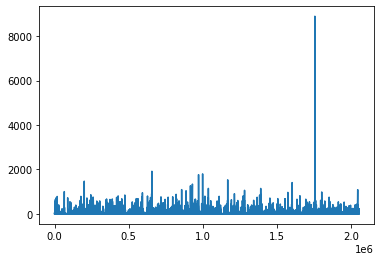

In [6]:
# Plotting all 'frp_max' values in the last 6 years
wf_all['frp_max']
plt.plot(wf_all['frp_max'])
plt.show()


In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
target=wf_all['cat']
dataset = wf_all.drop(['location','frp_max','cat'], axis = 1)
dataset.set_index('acq_date', inplace=True)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,19] = encoder.fit_transform(values[:,19])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# Showing the input set for our LSTM model
print(reframed.head())

# Printing the class split for this 40 column input
print(target.value_counts(),'\n')

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.352941   0.354167        0.0   0.481752   0.333333   0.500000   
2   0.392157   0.416667        0.0   0.372263   0.222222   0.586957   
3   0.352941   0.416667        0.0   0.481752   0.333333   0.565217   
4   0.372549   0.395833        0.0   0.481752   0.333333   0.586957   
5   0.450980   0.458333        0.0   0.481752   0.333333   0.652174   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  ...  \
1   0.365385   0.319149   0.372549    0.096552        0.08    0.666667  ...   
2   0.403846   0.361702   0.411765    0.137931        0.56    0.760417  ...   
3   0.384615   0.340426   0.392157    0.131034        0.33    0.729167  ...   
4   0.403846   0.361702   0.411765    0.137931        0.24    0.750000  ...   
5   0.461538   0.404255   0.470588    0.179310        0.29    0.781250  ...   

    var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
1  0.411765  0.137931  

In [8]:
# Split into train and test sets (Note: That we call this as test set but it is the validation set. The test set is new daily sample we get each day)
# We do a 70-30 train and validation split
values = reframed.values
n_train_hours = round(0.7*len(values))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train, target[:n_train_hours]
test_X, test_y = test, target[n_train_hours+1:]


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print('Train Feature-set:',train_X.shape)
print('Train Class set: ',train_y.shape)
print('Test Feature-set: ',test_X.shape)
print('Test Class set: ',test_y.shape)

Train Feature-set: (1438317, 1, 40)
Train Class set:  (1438317,)
Test Feature-set:  (616421, 1, 40)
Test Class set:  (616421,)


In [9]:
# To counter class-imbalance, we provide these class_weights as input to the weights our model takes

from sklearn.utils import class_weight
calculated_weights = class_weight.compute_class_weight('balanced',np.unique(train_y),train_y)

class_weight = {0 : calculated_weights[0] ,1: calculated_weights[1]}

print('Class weights supplied to the model is :', class_weight)

Class weights supplied to the model is : {0: 0.517697538347246, 1: 14.626258414854888}


In [12]:
# We first fix the epochs for each case here


epochs=50
# 1- Add dropout
# NOTE that here we apply dropout to the input layer only. Alternatively, we can apply this to our hidden layers as well 
# Range of values = [0.1,0.5,0.9]
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
dr_rt=[0.1,0.5,0.9]
acc_dropout=[]
rec_dropout=[]
for i in dr_rt:
    model_dropout = Sequential()
    model_dropout.add(LSTM(units=50,input_shape=[train_X.shape[1], train_X.shape[2]]))
    model_dropout.add(Dropout(i,noise_shape=None,seed=None))
    model_dropout.add(Dense(units=1, activation='sigmoid'))
    model_dropout.compile(loss='binary_crossentropy', optimizer='SGD',metrics=['acc',keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")])
    # Fit Network
    fit_model_dropout = model_dropout.fit(train_X, train_y, epochs=epochs, batch_size=1000,class_weight=class_weight, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    acc_dropout.append(fit_model_dropout.history['val_acc'][epochs-1])
    rec_dropout.append(fit_model_dropout.history['val_recall'][epochs-1])


# Testing with diffrent Learning Rate
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
lr_sgd=[0.001,0.005,0.01]
acc_lr_sgd=[]
rec_lr_sgd=[]
for i in lr_sgd:
    model_lr_sgd = Sequential()
    model_lr_sgd.add(LSTM(units=50,input_shape=[train_X.shape[1], train_X.shape[2]]))
    model_lr_sgd.add(Dropout(0.1,noise_shape=None,seed=None))
    model_lr_sgd.add(Dense(units=1, activation='sigmoid'))
    opt = tf.keras.optimizers.SGD(lr=i)
    model_lr_sgd.compile(loss='binary_crossentropy', optimizer=opt,metrics=['acc',keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")])
    # Fit Network
    fit_model_lr_sgd = model_lr_sgd.fit(train_X, train_y, epochs=epochs, batch_size=1000,class_weight=class_weight, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    acc_lr_sgd.append(fit_model_lr_sgd.history['val_acc'][epochs-1])
    rec_lr_sgd.append(fit_model_lr_sgd.history['val_recall'][epochs-1])

# Testing with different Momentum  
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
mo_sgd=[0.1,0.5,0.9]
acc_mo_sgd=[]
rec_mo_sgd=[]
for i in mo_sgd:
    model_mo_sgd = Sequential()
    model_mo_sgd.add(LSTM(units=50,input_shape=[train_X.shape[1], train_X.shape[2]]))
    model_mo_sgd.add(Dropout(0.1,noise_shape=None,seed=None))
    model_mo_sgd.add(Dense(units=1, activation='sigmoid'))
    opt = tf.keras.optimizers.SGD(lr=0.01,momentum=i)
    model_mo_sgd.compile(loss='binary_crossentropy', optimizer=opt,metrics=['acc',keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")])
    # Fit Network
    fit_model_mo_sgd = model_mo_sgd.fit(train_X, train_y, epochs=epochs, batch_size=1000,class_weight=class_weight, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    acc_mo_sgd.append(fit_model_mo_sgd.history['val_acc'][epochs-1])
    rec_mo_sgd.append(fit_model_mo_sgd.history['val_recall'][epochs-1])


# Testing with different Optimizer - Adam and at different learning rates  
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
lr_ad=[0.001,0.005,0.01]
acc_lr_ad=[]
rec_lr_ad=[]
for i in lr_ad:
    model_lr_ad = Sequential()
    model_lr_ad.add(LSTM(units=50,input_shape=[train_X.shape[1], train_X.shape[2]]))
    model_lr_ad.add(Dropout(0.1,noise_shape=None,seed=None))
    model_lr_ad.add(Dense(units=1, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(lr=i)
    model_lr_ad.compile(loss='binary_crossentropy', optimizer=opt,metrics=['acc',keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")])
    # Fit Network
    fit_model_lr_ad = model_lr_ad.fit(train_X, train_y, epochs=epochs, batch_size=1000,class_weight=class_weight, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    acc_lr_ad.append(fit_model_lr_ad.history['val_acc'][epochs-1])
    rec_lr_ad.append(fit_model_lr_ad.history['val_recall'][epochs-1])


Epoch 1/50
1439/1439 - 15s - loss: 0.6638 - acc: 0.5870 - precision: 0.0532 - recall: 0.6591 - val_loss: 0.6379 - val_acc: 0.7402 - val_precision: 0.0759 - val_recall: 0.6391
Epoch 2/50
1439/1439 - 12s - loss: 0.5930 - acc: 0.7553 - precision: 0.0892 - recall: 0.6687 - val_loss: 0.5268 - val_acc: 0.8074 - val_precision: 0.0918 - val_recall: 0.5666
Epoch 3/50
1439/1439 - 12s - loss: 0.5322 - acc: 0.7885 - precision: 0.1035 - recall: 0.6767 - val_loss: 0.4507 - val_acc: 0.8256 - val_precision: 0.0983 - val_recall: 0.5463
Epoch 4/50
1439/1439 - 12s - loss: 0.5091 - acc: 0.7970 - precision: 0.1085 - recall: 0.6844 - val_loss: 0.4233 - val_acc: 0.8325 - val_precision: 0.1023 - val_recall: 0.5463
Epoch 5/50
1439/1439 - 12s - loss: 0.4996 - acc: 0.8023 - precision: 0.1121 - recall: 0.6911 - val_loss: 0.4101 - val_acc: 0.8382 - val_precision: 0.1063 - val_recall: 0.5492
Epoch 6/50
1439/1439 - 12s - loss: 0.4932 - acc: 0.8063 - precision: 0.1152 - recall: 0.6986 - val_loss: 0.4015 - val_acc: 0.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
1439/1439 - 15s - loss: 0.6989 - acc: 0.7329 - precision: 0.0249 - recall: 0.1785 - val_loss: 0.6910 - val_acc: 0.5776 - val_precision: 0.0258 - val_recall: 0.3322
Epoch 2/50
1439/1439 - 12s - loss: 0.6910 - acc: 0.5600 - precision: 0.0384 - recall: 0.4943 - val_loss: 0.7006 - val_acc: 0.3612 - val_precision: 0.0373 - val_recall: 0.7661
Epoch 3/50
1439/1439 - 12s - loss: 0.6839 - acc: 0.5350 - precision: 0.0472 - recall: 0.6571 - val_loss: 0.7005 - val_acc: 0.3943 - val_precision: 0.0422 - val_recall: 0.8297
Epoch 4/50
1439/1439 - 12s - loss: 0.6769 - acc: 0.5869 - precision: 0.0562 - recall: 0.7014 - val_loss: 0.6963 - val_acc: 0.5019 - val_precision: 0.0496 - val_recall: 0.8035
Epoch 5/50
1439/1439 - 12s - loss: 0.6700 - acc: 0.6472 - precision: 0.0654 - recall: 0.7016 - val_loss: 0.6905 - val_acc: 0.5789 - val_precision: 0.0565 - val_recall: 0.7761
Epoch 6/50
1439/1439 - 12s - loss: 0.6628 - acc: 0.6937 - precision: 0.0745 - recall: 0.6969 - val_loss: 0.6840 - val_acc: 0.

Validation Accuracy for Dropout:  0.8323321342468262
Validation Accuracy for SGD Optimizer - Different Learning Rates:  0.8333525061607361
Validation Accuracy for SGD Optimizer - Different Momentum:  0.8482011556625366
Validation Accuracy for SGD Optimizer - Different Learning Rates:  0.8332211375236511


Validation Recall for Dropout:  0.6108682155609131
Validation Recall for SGD Optimizer - Different Learning Rates:  0.6667344570159912
Validation Recall for SGD Optimizer - Different Momentum:  0.6022264957427979
Validation Recall for SGD Optimizer - Different Learning Rates:  0.6740036606788635


 Accuracy Plots for tuned hyperparameters:



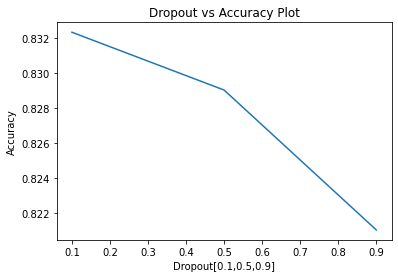

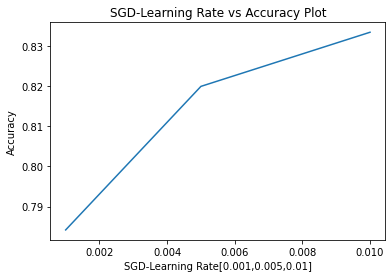

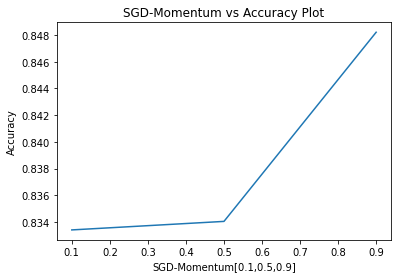

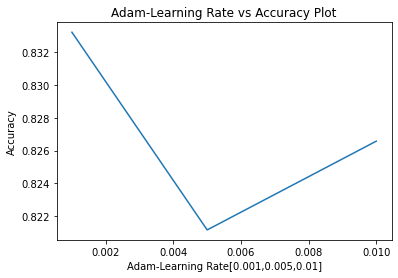

In [14]:
# We take the best accuracy we achieve for each configuration and print it to fill the table
print('Validation Accuracy for Dropout: ',max(acc_dropout))
print('Validation Accuracy for SGD Optimizer - Different Learning Rates: ',max(acc_lr_sgd))
print('Validation Accuracy for SGD Optimizer - Different Momentum: ',max(acc_mo_sgd))
print('Validation Accuracy for SGD Optimizer - Different Learning Rates: ',max(acc_lr_ad))

# We take the best recall we achieve for each configuration and print it to fill the table
print('\n\nValidation Recall for Dropout: ',max(rec_dropout))
print('Validation Recall for SGD Optimizer - Different Learning Rates: ',max(rec_lr_sgd))
print('Validation Recall for SGD Optimizer - Different Momentum: ',max(rec_mo_sgd))
print('Validation Recall for SGD Optimizer - Different Learning Rates: ',max(rec_lr_ad))

print('\n\n Accuracy Plots for tuned hyperparameters:\n')
# Here we show the plots for each configuration we tuned by trying various values and show its accuracy vs value
#For Dropout
plt.plot(dr_rt,acc_dropout)
plt.xlabel('Dropout[0.1,0.5,0.9]')
plt.ylabel('Accuracy')
plt.title('Dropout vs Accuracy Plot')
plt.show()
plt.plot(lr_sgd,acc_lr_sgd)
plt.xlabel('SGD-Learning Rate[0.001,0.005,0.01]')
plt.ylabel('Accuracy')
plt.title('SGD-Learning Rate vs Accuracy Plot')
plt.show()
plt.plot(mo_sgd,acc_mo_sgd)
plt.xlabel('SGD-Momentum[0.1,0.5,0.9]')
plt.ylabel('Accuracy')
plt.title('SGD-Momentum vs Accuracy Plot')
plt.show()
plt.plot(lr_ad,acc_lr_ad)
plt.xlabel('Adam-Learning Rate[0.001,0.005,0.01]')
plt.ylabel('Accuracy')
plt.title('Adam-Learning Rate vs Accuracy Plot')
plt.show()



 Recall Plots for tuned hyperparameters:



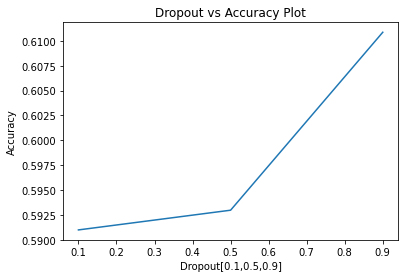

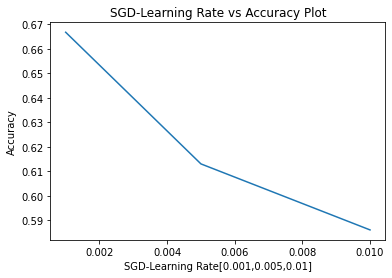

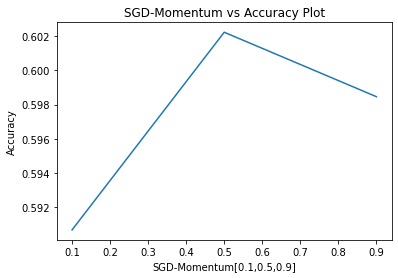

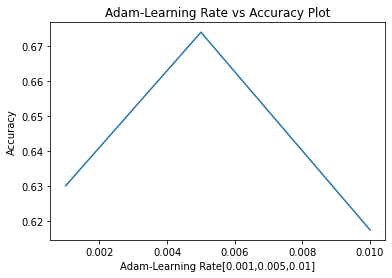

In [15]:
print('\n\n Recall Plots for tuned hyperparameters:\n')
# Here we show the plots for each configuration we tuned by trying various values and show its recall vs value
#For Dropout
plt.plot(dr_rt,rec_dropout)
plt.xlabel('Dropout[0.1,0.5,0.9]')
plt.ylabel('Accuracy')
plt.title('Dropout vs Accuracy Plot')
plt.show()
plt.plot(lr_sgd,rec_lr_sgd)
plt.xlabel('SGD-Learning Rate[0.001,0.005,0.01]')
plt.ylabel('Accuracy')
plt.title('SGD-Learning Rate vs Accuracy Plot')
plt.show()
plt.plot(mo_sgd,rec_mo_sgd)
plt.xlabel('SGD-Momentum[0.1,0.5,0.9]')
plt.ylabel('Accuracy')
plt.title('SGD-Momentum vs Accuracy Plot')
plt.show()
plt.plot(lr_ad,rec_lr_ad)
plt.xlabel('Adam-Learning Rate[0.001,0.005,0.01]')
plt.ylabel('Accuracy')
plt.title('Adam-Learning Rate vs Accuracy Plot')
plt.show()

|Dropout (rate)   | Optimiser  | Learning Rate| Momentum| Number of Epochs |Validation Accuracy(%)| Recall (%)
|---|---|---|---|---|---|---|
|0.1  |SGD   |0.001 |     0.01     |50 | 83.23|59.09|
|0.5  |SGD   |0.001 |     0.01     |50 | 82.90|59.29|
|0.9 |SGD   |0.001 |     0.01    |50 | 82.10|61.08|
|0.1   |SGD   |0.001 |     0.01     |50 |78.41|66.67|
|0.1   |SGD   |0.005 |    0.01  |50 |81.98|61.30|
|0.1   |SGD   |0.01 |  0.01  |50 | 83.33|58.60|
|0.1  |SGD   |0.001 | 0.1  |50 | 83.34|59.06|
|0.1   |SGD   |0.001 | 0.5 |50 | 82.40|60.22|
|0.1   |SGD   |0.001 |    0.9      |50   | 84.82|59.84|
|0.1   |Adam   |0.001 |    -      |50 | 83.32|63.01|
|0.1   |Adam   |0.005 |    -      |50 | 82.11|67.40|
|0.1   |Adam   |0.01 |    -      |50 | 82.65|61.75|



In [19]:
# Network Architecture LSTM
import keras
model = Sequential()
model.add(LSTM(units=50,input_shape=[train_X.shape[1], train_X.shape[2]]))
model.add(Dropout(0.9,noise_shape=None,seed=None))
model.add(Dense(units=1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(lr=0.005)
model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['acc',keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")])
# Fit Network
history = model.fit(train_X, train_y, epochs=20, batch_size=1000,class_weight=class_weight, validation_data=(test_X, test_y), verbose=2, shuffle=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
1439/1439 - 15s - loss: 0.6001 - acc: 0.7360 - precision: 0.0744 - recall: 0.5873 - val_loss: 0.2826 - val_acc: 0.9246 - val_precision: 0.1433 - val_recall: 0.2734
Epoch 2/20
1439/1439 - 13s - loss: 0.5313 - acc: 0.7890 - precision: 0.1023 - recall: 0.6650 - val_loss: 0.2953 - val_acc: 0.9168 - val_precision: 0.1486 - val_recall: 0.3399
Epoch 3/20
1439/1439 - 13s - loss: 0.5177 - acc: 0.7878 - precision: 0.1035 - recall: 0.6797 - val_loss: 0.3155 - val_acc: 0.9069 - val_precision: 0.1455 - val_recall: 0.3936
Epoch 4/20
1439/1439 - 13s - loss: 0.5111 - acc: 0.7812 - precision: 0.1024 - recall: 0.6953 - val_loss: 0.2871 - val_acc: 0.9207 - val_precision: 0.1673 - val_recall: 0.3736
Epoch 5/20
1439/1439 - 13s - loss: 0.5092 - acc: 0.7851 - precision: 0.1042 - recall: 0.6962 - val_loss: 0.3259 - val_acc: 0.9067 - val_precision: 0.1539 - val_recall: 0.4275
Epoch 6/20
1439/1439 - 13s - loss: 0.5051 - acc: 0.7819 - precision: 0.1039 - recall: 0.7056 - val_loss: 0.3468 - val_acc: 0.

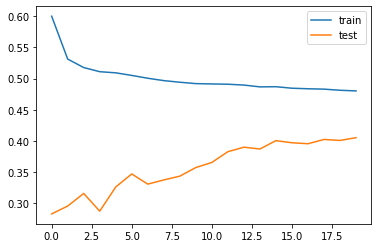

In [20]:
# Plotting history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
pred_y = model.predict(test_X)

In [21]:
# Getting the final confusion matrix and classification report 

pred_cls=[]
for i, predicted in enumerate(pred_y):
    x=0
    if predicted[0] > 0.5:
        x= 1
    else:
        x= 0
    pred_cls.append(x)


#MEASURES
cm = confusion_matrix(test_y, pred_cls)
print(cm)
cr = classification_report(test_y, pred_cls)

print(cr)


[[502918  93831]
 [  7519  12153]]
              precision    recall  f1-score   support

           0       0.99      0.84      0.91    596749
           1       0.11      0.62      0.19     19672

    accuracy                           0.84    616421
   macro avg       0.55      0.73      0.55    616421
weighted avg       0.96      0.84      0.89    616421



In [22]:
# Testing at different thresholds 
# Getting the final confusion matrix and classification report 

pred_cls=[]
for i, predicted in enumerate(pred_y):
    x=0
    if predicted[0] > 0.45:
        x= 1
    else:
        x= 0
    pred_cls.append(x)


#MEASURES
cm = confusion_matrix(test_y, pred_cls)
print(cm)
cr = classification_report(test_y, pred_cls)

print(cr)





[[477487 119262]
 [  6615  13057]]
              precision    recall  f1-score   support

           0       0.99      0.80      0.88    596749
           1       0.10      0.66      0.17     19672

    accuracy                           0.80    616421
   macro avg       0.54      0.73      0.53    616421
weighted avg       0.96      0.80      0.86    616421

